<a href="https://colab.research.google.com/github/r0b0t-x/eyewitness/blob/master/eyewitness.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Face Recognition Using Siamese Network

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


##Get Data
We will understand the siamese network by building the face recognition model. The objective of our network is to understand whether two faces are similar or dissimilar. We use AT & T's the Database of Faces which can be downloaded from here (https://www.cl.cam.ac.uk/research/dtg/attarchive/facedatabase.html)

Once you have downloaded and extracted the archive, you can see the folders like s1, s2 up to s40 as shown here:

In [2]:
!wget http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip

--2019-05-12 15:32:44--  http://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip
Resolving www.cl.cam.ac.uk (www.cl.cam.ac.uk)... 128.232.0.20, 2a05:b400:110::80:14
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip [following]
--2019-05-12 15:32:45--  https://www.cl.cam.ac.uk/Research/DTG/attarchive/pub/data/att_faces.zip
Connecting to www.cl.cam.ac.uk (www.cl.cam.ac.uk)|128.232.0.20|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip [following]
--2019-05-12 15:32:45--  https://www.cl.cam.ac.uk/research/dtg/attarchive/pub/data/att_faces.zip
Reusing existing connection to www.cl.cam.ac.uk:443.
HTTP request sent, awaiting response... 200 OK
Length: 3769022 (3.6M) [application/zip]
Saving to: ‘att_faces.

In [0]:
!mkdir 'gdrive/My Drive/documents/work/youngee'

In [0]:
!unzip att_faces.zip -d 'gdrive/My Drive/documents/work/youngee'

Each of these folders has 10 different images of a single person taken from various angles. For an instance, let us open folder s1. As you can see, there are 10 different images of a single person:

In [67]:
!ls 'gdrive/My Drive/documents/work/youngee'

README	s11  s14  s17  s2   s22  s25  s28  s30	s33  s36  s39  s5  s8
s1	s12  s15  s18  s20  s23  s26  s29  s31	s34  s37  s4   s6  s9
s10	s13  s16  s19  s21  s24  s27  s3   s32	s35  s38  s40  s7


In [0]:
DATA_PATH = 'gdrive/My Drive/documents/work/youngee'

##Import libraries
First, we will import the required libraries.

In [0]:
import re
import numpy as np
from PIL import Image

from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop

##Read image as numpy array
Now, we define a function for reading our input image. The function read_image takes input as an image and returns the numpy array.

In [0]:
def read_image(filename, byteorder='>'):
    
    #first we read the image, as a raw file to the buffer
    with open(filename, 'rb') as f:
        buffer = f.read()
    
    #using regex, we extract the header, width, height and maxval of the image
    header, width, height, maxval = re.search(
        b"(^P5\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n])*"
        b"(\d+)\s(?:\s*#.*[\r\n]\s)*)", buffer).groups()
    
    #then we convert the image to numpy array using np.frombuffer which interprets buffer as one dimensional array
    return np.frombuffer(buffer,
                            dtype='u1' if int(maxval) < 256 else byteorder+'u2',
                            count=int(width)*int(height),
                            offset=len(header)
                            ).reshape((int(height), int(width)))

##Visualize Sample image
For an example, Let us open one image,

In [0]:
image_path = "{}/s1/1.pgm".format(DATA_PATH)

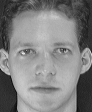

In [26]:
Image.open(image_path)

##Read image as an array
When we feed this image to our read_image function, it will return as the numpy array,

In [27]:
img = read_image(image_path)
img.shape

(112, 92)

##Get Image Pair
As we know that siamese networks require inputs as a pair along with the label, we have to create our data in such a way. So we will take two images randomly from the same folder and mark it as a genuine pair and we will take a single image from two different folders and mark them as an imposite pair. A sample data is shown in the below figure, as you can notice a genuine pair has images of the same person and imposite pair has images of a different person.

In [0]:
import glob

data = glob.glob(DATA_PATH+"/*/")

size = 2
total_sample_size = len(data)


def get_data(size, total_sample_size):
    #read the image
    image = read_image(DATA_PATH+'/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    
    #reduce the size
    image = image[::size, ::size]
    
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image(DATA_PATH+'/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image(DATA_PATH+'/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image(DATA_PATH+'/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image(DATA_PATH+'/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

Now, we define another function get_data for generating our data. As we know, for the Siamese network, data should be in the form of pairs (genuine and imposite) with a binary label.

First, we read the images (img1, img2) from the same directory and store them in the x_genuine_pair array and assign y_genuine to 1. Next, we read the images (img1, img2) from the different directory and store them in the x_imposite pair and assign y_imposite to 0.

Finally, we concatenate both x_genuine_pair, x_imposite to X and y_genuine, y_imposite to Y:

In [0]:
size = 2
total_sample_size = 10000


def get_data(size, total_sample_size):
    #read the image
    image = read_image(DATA_PATH+'/s' + str(1) + '/' + str(1) + '.pgm', 'rw+')
    
    #reduce the size
    image = image[::size, ::size]
    
    #get the new size
    dim1 = image.shape[0]
    dim2 = image.shape[1]

    count = 0
    
    #initialize the numpy array with the shape of [total_sample, no_of_pairs, dim1, dim2]
    x_geuine_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2]) # 2 is for pairs
    y_genuine = np.zeros([total_sample_size, 1])
    
    for i in range(40):
        for j in range(int(total_sample_size/40)):
            ind1 = 0
            ind2 = 0
            
            #read images from same directory (genuine pair)
            while ind1 == ind2:
                ind1 = np.random.randint(10)
                ind2 = np.random.randint(10)
            
            # read the two images
            img1 = read_image(DATA_PATH+'/s' + str(i+1) + '/' + str(ind1 + 1) + '.pgm', 'rw+')
            img2 = read_image(DATA_PATH+'/s' + str(i+1) + '/' + str(ind2 + 1) + '.pgm', 'rw+')
            
            #reduce the size
            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]
            
            #store the images to the initialized numpy array
            x_geuine_pair[count, 0, 0, :, :] = img1
            x_geuine_pair[count, 1, 0, :, :] = img2
            
            #as we are drawing images from the same directory we assign label as 1. (genuine pair)
            y_genuine[count] = 1
            count += 1

    count = 0
    x_imposite_pair = np.zeros([total_sample_size, 2, 1, dim1, dim2])
    y_imposite = np.zeros([total_sample_size, 1])
    
    for i in range(int(total_sample_size/10)):
        for j in range(10):
            
            #read images from different directory (imposite pair)
            while True:
                ind1 = np.random.randint(40)
                ind2 = np.random.randint(40)
                if ind1 != ind2:
                    break
                    
            img1 = read_image(DATA_PATH+'/s' + str(ind1+1) + '/' + str(j + 1) + '.pgm', 'rw+')
            img2 = read_image(DATA_PATH+'/s' + str(ind2+1) + '/' + str(j + 1) + '.pgm', 'rw+')

            img1 = img1[::size, ::size]
            img2 = img2[::size, ::size]

            x_imposite_pair[count, 0, 0, :, :] = img1
            x_imposite_pair[count, 1, 0, :, :] = img2
            #as we are drawing images from the different directory we assign label as 0. (imposite pair)
            y_imposite[count] = 0
            count += 1
            
    #now, concatenate, genuine pairs and imposite pair to get the whole data
    X = np.concatenate([x_geuine_pair, x_imposite_pair], axis=0)/255
    Y = np.concatenate([y_genuine, y_imposite], axis=0)

    return X, Y

##Train network
Once we have our data as pairs along with their labels, we train our siamese network. From the image pair, we feed one image to the network A and another image to the network B. The role of these two networks is only to extract the feature vectors. So, we use two convolution layers with relu activations for extracting the features. Once we have learned the feature, we feed the resultant feature vector from both of the networks to the energy function which measures the similarity, we use Euclidean distance as our energy function. So, we train our network by feeding the image pair to learn the semantic similarity between them. Now, we will see this step by step.

Now, we generate our data and check our data size. As you can see we have 20,000 data points, out of these 10,000 are genuine pairs and 10,000 are imposite pairs. 

In [0]:
X, Y = get_data(size, total_sample_size)

In [32]:
X.shape

(20000, 2, 1, 56, 46)

In [33]:
Y.shape

(20000, 1)

Next, we split our data for training and testing with 75% training and 25% testing proportions:

In [0]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=.25)

Now that, we have successfully generated our data, we build our siamese network. First, we define the base network which is basically a convolutional network used for feature extraction. We build two convolutional layers with rectified linear unit (ReLU) activations and max pooling followed by flat layer.

In [0]:
def build_base_network(input_shape):
    
    seq = Sequential()
    
    nb_filter = [6, 12]
    kernel_size = 3
    
    
    #convolutional layer 1
    seq.add(Convolution2D(nb_filter[0], kernel_size, kernel_size, input_shape=input_shape,
                          border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2)))  
    seq.add(Dropout(.25))
    
    #convolutional layer 2
    seq.add(Convolution2D(nb_filter[1], kernel_size, kernel_size, border_mode='valid', dim_ordering='th'))
    seq.add(Activation('relu'))
    seq.add(MaxPooling2D(pool_size=(2, 2), dim_ordering='th')) 
    seq.add(Dropout(.25))

    #flatten 
    seq.add(Flatten())
    seq.add(Dense(128, activation='relu'))
    seq.add(Dropout(0.1))
    seq.add(Dense(50, activation='relu'))
    return seq


Next, we feed the image pair, to the base network, which will return the embeddings that is, feature vectors:

In [0]:
input_dim = x_train.shape[2:]
img_a = Input(shape=input_dim)
img_b = Input(shape=input_dim)

In [41]:
base_network = build_base_network(input_dim)
feat_vecs_a = base_network(img_a)
feat_vecs_b = base_network(img_b)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), input_shape=(1, 56, 46..., padding="valid", data_format="channels_first")`
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (3, 3), padding="valid", data_format="channels_first")`
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: UserWarning: Update your `MaxPooling2D` call to the Keras 2 API: `MaxPooling2D(pool_size=(2, 2), data_format="channels_first")`


These feat_vecs_a and feat_vecs_b are the feature vectors of our image pair. Next, we feed this feature vectors to the energy function to compute the distance between them, we use Euclidean distance as our energy function.

In [0]:
def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))


def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

In [0]:
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([feat_vecs_a, feat_vecs_b])

 Now, we set the epoch length to 13 and we use RMS prop for optimization and define our model.

In [0]:
epochs = 13
rms = RMSprop()

In [46]:
model = Model(input=[img_a, img_b], output=distance)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("la...)`
  """Entry point for launching an IPython kernel.


Next, we define our loss function as contrastive_loss function and compile the model. 

In [0]:
def contrastive_loss(y_true, y_pred):
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [0]:
model.compile(loss=contrastive_loss, optimizer=rms)

In [0]:
img_1 = x_train[:, 0]
img2 = x_train[:, 1]

In [50]:
model.fit([img_1, img2], y_train, validation_split=.25,
          batch_size=128, verbose=2, nb_epoch=epochs)

Instructions for updating:
Use tf.cast instead.


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Train on 11250 samples, validate on 3750 samples
Epoch 1/13
 - 44s - loss: 0.2435 - val_loss: 0.2869
Epoch 2/13
 - 44s - loss: 0.1652 - val_loss: 0.2704
Epoch 3/13
 - 44s - loss: 0.1265 - val_loss: 0.1953
Epoch 4/13
Epoch 5/13
 - 44s - loss: 0.0836 - val_loss: 0.1140
Epoch 6/13
 - 44s - loss: 0.0681 - val_loss: 0.0802
Epoch 7/13
 - 44s - loss: 0.0573 - val_loss: 0.0678
Epoch 8/13
 - 44s - loss: 0.0513 - val_loss: 0.0513
Epoch 9/13
 - 44s - loss: 0.0454 - val_loss: 0.0520
Epoch 10/13
 - 44s - loss: 0.0402 - val_loss: 0.0390
Epoch 11/13
 - 44s - loss: 0.0369 - val_loss: 0.0384
Epoch 12/13
 - 44s - loss: 0.0331 - val_loss: 0.0292
Epoch 13/13
 - 44s - loss: 0.0313 - val_loss: 0.0350


Now, we make predictions with test data

In [0]:
pred = model.predict([x_test[:, 0], x_test[:, 1]])

In [0]:
def compute_accuracy(predictions, labels):
    return labels[predictions.ravel() < 0.5].mean()

Finally, we check our model accuracy. 

In [53]:
compute_accuracy(pred, y_test)

0.9300673148840688

In [62]:
x_test[0, 0].shape
model.predict([x_test[:1, 0], x_test[:1, 1]])

array([[0.5666597]], dtype=float32)

In [63]:
pred

array([[0.5666596 ],
       [0.01803328],
       [0.03845473],
       ...,
       [1.0385535 ],
       [0.10629258],
       [0.8508386 ]], dtype=float32)

In [64]:
y_test

array([[0.],
       [1.],
       [1.],
       ...,
       [0.],
       [1.],
       [0.]])